In [1]:
from dg_ml_core.collections import dict_ops
from dg_ml_core import file
from dg_ml_core.datastores import gcs_utils
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=ResourceWarning)
import json
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

# Generate Table of dataset stats

## Generate events_per_user.json

In [5]:
dataset = 'micro_dataset'
data_prefix = f'gs://ma-muy/03_datasets/{dataset}/01_complete'
file_paths = file.get_paths_with_prefix(data_prefix)
gcs_client = gcs_utils.get_client('machinelearning-prod', None)

events_per_user = dict()

for file_path in file_paths:
    print('=', end='')
    sessions_by_user = dict_ops.load_dict(file_path, gcs_client=gcs_client)
    for user in sessions_by_user:
        num_events = 0
        for session in sessions_by_user[user]:
            num_events += len(sessions_by_user[user][session]['Events'])
        if num_events < 20000:
            events_per_user[user] = num_events
        
dict_ops.save_dict(f'gs://ma-muy/03_datasets/{dataset}/08_events_per_user.json', events_per_user)

===

In [8]:
def get_mean_std_string(key, dataset_stats):
    return str(np.round(dataset_stats['mean_' + key], 2)) + ' $\\pm$ ' + str(np.round(dataset_stats['std_' + key], 2))

def get_grouped_number(number):
    if len(number) > 3:
        return f'{int(number):,}'.replace(",", "'")
    else:
        return number

dataset_names = ['micro', 'midi', 'maxi']
stats_strings = dict()
for dataset in dataset_names:
    stats_path = f"gs://ma-muy/03_datasets/{dataset}_dataset/03_dataset_stats.json"
    dataset_stats = dict_ops.load_dict(stats_path)
    events_per_user = dict_ops.load_dict(f'gs://ma-muy/03_datasets/{dataset}_dataset/08_events_per_user.json')
    dataset_stats['mean_events_per_user'] = np.mean(list(events_per_user.values()))
    dataset_stats['std_events_per_user'] = np.std(list(events_per_user.values()))
    stats_strings[dataset] = []
    stats_strings[dataset].append(get_grouped_number(str(dataset_stats['num_users'])))
    stats_strings[dataset].append(get_grouped_number(str(dataset_stats['num_products'])))
    stats_strings[dataset].append(get_grouped_number(str(dataset_stats['num_events'])))
    stats_strings[dataset].append(get_grouped_number(str(dataset_stats['num_sessions'])))
    stats_strings[dataset].append(get_mean_std_string('sessions_per_user', dataset_stats))
    stats_strings[dataset].append(get_mean_std_string('events_per_product', dataset_stats))
    stats_strings[dataset].append(get_mean_std_string('events_per_session', dataset_stats))
    stats_strings[dataset].append(get_mean_std_string('events_per_user', dataset_stats))

headers = ['Property', 'MINI Dataset', 'MIDI Dataset', 'MAXI Dataset']
property_names = ['\\#Users', '\\#Products', '\\#Events', '\\#Sessions', '\\#Sessions per User', '\\#Events per Product', '\\#Events per Session', '\\#Events per User']
print(' & '.join(headers) + ' \\\\')
for a, b, c, d in zip(property_names, stats_strings['micro'], stats_strings['midi'], stats_strings['maxi']):
    print(f"{a} & {b} & {c} & {d} \\\\")

Property & MINI Dataset & MIDI Dataset & MAXI Dataset \\
\#Users & 23 & 15'242 & 242'797 \\
\#Products & 161 & 42'103 & 470'817 \\
\#Events & 633 & 1'234'697 & 28'726'701 \\
\#Sessions & 183 & 250'187 & 4'652'496 \\
\#Sessions per User & 7.96 $\pm$ 5.41 & 16.41 $\pm$ 22.08 & 19.16 $\pm$ 28.67 \\
\#Events per Product & 3.93 $\pm$ 5.84 & 29.33 $\pm$ 69.98 & 61.27 $\pm$ 263.3 \\
\#Events per Session & 3.46 $\pm$ 0.82 & 4.94 $\pm$ 3.07 & 6.17 $\pm$ 60.22 \\
\#Events per User & 27.52 $\pm$ 19.8 & 81.01 $\pm$ 135.35 & 115.05 $\pm$ 215.15 \\


# Generate Histogram of Visits per Product/User

In [14]:
def generate_histogram(events, filename):
    ax = sns.distplot(events, kde=False, hist_kws={'log':True})
    ax.set_ylabel('#Users', fontsize=15)
    ax.set_xlabel('#Events', fontsize=15)
    ax.get_figure().savefig('../writeup/plots/' + filename, dpi=200)

## Download relevant files

In [148]:
file_path = 'gs://ma-muy/03_datasets/maxi_dataset/02_events_per_product.json'
file.copy_file(file_path, 'events_per_product.json')
file_path = 'gs://ma-muy/03_datasets/maxi_dataset/08_events_per_user.json'
file.copy_file(file_path, 'events_per_user.json')

## Generate Histograms

Number of products: 470817


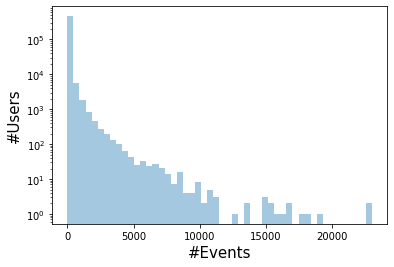

In [15]:
events_per_product = dict_ops.load_dict('events_per_product.json')
events = list(events_per_product.values())
print("Number of products:", len(events))
generate_histogram(events, "histo_product_visits.png")

Number of users: 242794


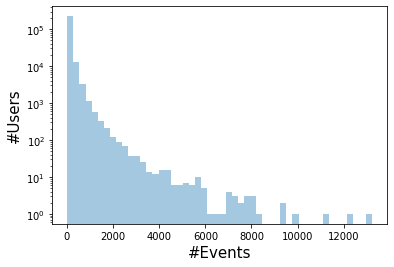

In [16]:
events_per_user = dict_ops.load_dict('events_per_user.json')
events = list(events_per_user.values())
print("Number of users:", len(events))
generate_histogram(events, "histo_user_visits.png")

# Generate PCA of user/product embeddings

## Download relevant files

In [30]:
product_embeddings_path = 'gs://ma-muy/product_embeddings.json'
file.copy_file(product_embeddings_path, 'product_embeddings.json')
print(len(dict_ops.load_dict('product_embeddings.json')).keys())
user_embeddings_path = 'gs://ma-muy/04_model_artifacts/with_user_one_hot/1/user_embeddings.json'
file.copy_file(user_embeddings_path, 'user_embeddings.json')
print(len(dict_ops.load_dict('user_embeddings.json')).keys())

3269826
242797


## Filter product embeddings

In [6]:
relevant_product_ids = set(dict_ops.load_dict('gs://ma-muy/03_datasets/maxi_dataset/02_events_per_product.json').keys())
product_embeddings = dict_ops.load_dict('product_embeddings.json')
product_ids = list(product_embeddings.keys())
for product_id in product_ids:
    if product_id not in relevant_product_ids:
        _ = product_embeddings.pop(product_id, None)
dict_ops.save_dict('relevant_product_embeddings.json', product_embeddings)

## Generate PCAs

In [2]:
def compute_pca(freq_dict, embedding_dict, kernel=None):
    events_per_item = dict_ops.load_dict(freq_dict)
    embeddings = dict_ops.load_dict(embedding_dict)
    data = []
    embedding_size = 0
    for item_id in embeddings:
        if item_id in events_per_item:
            row = embeddings[item_id]
            embedding_size = len(row)
            if events_per_item[item_id] > 10000 and 'user' not in freq_dict:
                row.append('>10k')
            elif events_per_item[item_id] > 1000:
                row.append('>1k')
            elif events_per_item[item_id] > 100:
                row.append('>100')
            elif events_per_item[item_id] > 10:
                row.append('>10')
            else:
                row.append('<10')
            data.append(row)
    df = pd.DataFrame(data)
    print(df[embedding_size].value_counts())
    df = df.rename({embedding_size: "#Events"}, axis=1).groupby(by='#Events', as_index=False).apply(lambda x: x if len(x) < 1000 else x.sample(1000))
    features = [x for x in range(embedding_size)]
    target = '#Events'
    x = df.loc[:, features].values
    x = StandardScaler().fit_transform(x)
    if kernel is not None:
        pca = KernelPCA(n_components=2, kernel=kernel)
    else:
        pca = PCA(n_components=2)
    principal_components = pca.fit_transform(x)
    result_df = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])
    result_df = pd.concat([result_df, df.reset_index()[[target]]], axis=1, ignore_index=True)

    return result_df, df

def scatter_plot_pca(df, filename):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    # TODO: Targets extracted from df
    targets = df[2].unique()
#     colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'][:len(targets)]
    colors = ['darkorange', 'limegreen', 'tomato', 'gold', 'royalblue'][:len(targets)]
    for target, color in zip(targets, colors):
        indicesToKeep = df[2] == target
        ax.scatter(df.loc[indicesToKeep, 0], df.loc[indicesToKeep, 1], c = color, s = 50)
    ax.legend(targets)
    ax.grid()
    ax.get_figure().savefig('../writeup/plots/' + filename, dpi=200)
    
def bar_plot_separated(df, limit, filename, comparator):
    if comparator == '<':
        negative_indices = df[0] < limit
    else:
        negative_indices = df[0] > limit
    negative_indices_ratio = (df[negative_indices][2].value_counts() / df[2].value_counts()).sort_values()
    print(negative_indices_ratio)
    barWidth = 0.85
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    
    ax.bar(negative_indices_ratio.index, negative_indices_ratio.values, color='#b5ffb9', edgecolor='white', width=barWidth)
    ax.bar(negative_indices_ratio.index, 1-negative_indices_ratio.values, bottom=negative_indices_ratio.values, color='#f9bc86', edgecolor='white', width=barWidth)
    ax.set_xlabel("#Events", fontsize=15)
    ax.set_ylabel('Percentage of items', fontsize=15)
    inv_comparator = '>' if comparator == '<' else '<'
    ax.legend(['PC1 {} {}'.format(comparator, limit), 'PC1 {}= {}'.format(inv_comparator, limit)])
    ax.get_figure().savefig('../writeup/plots/' + filename, dpi=200)
    
def histogram_separated(df, filename):
    label_col = len(df.columns) - 1 if '#Events' not in df.columns else '#Events'
    few_visits = (df[label_col] == '<10')
    many_visits = ((df[label_col] == '>1k') | (df[label_col] == '10k'))
    sns.distplot(df[few_visits].drop(label_col, axis=1).to_numpy().flatten(), color='r')
    sns.distplot(df[many_visits].drop(label_col, axis=1).to_numpy().flatten(), color='b')
    # TODO: Save figures
    # TODO: Add legend

>10     250222
<10     171201
>100     44800
>1k       3608
>10k        29
Name: 25, dtype: int64
<10     0.230
>10     0.345
>100    0.557
>1k     0.862
>10k    1.000
Name: 2, dtype: float64


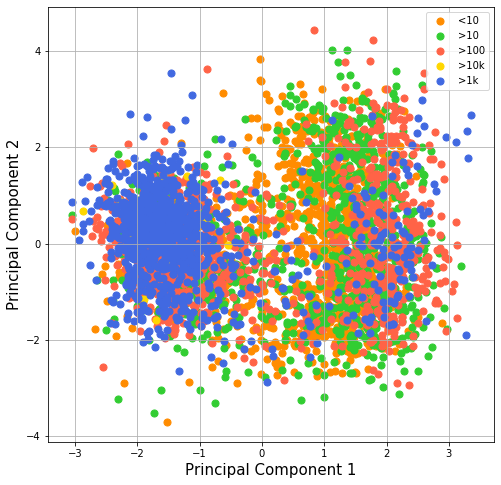

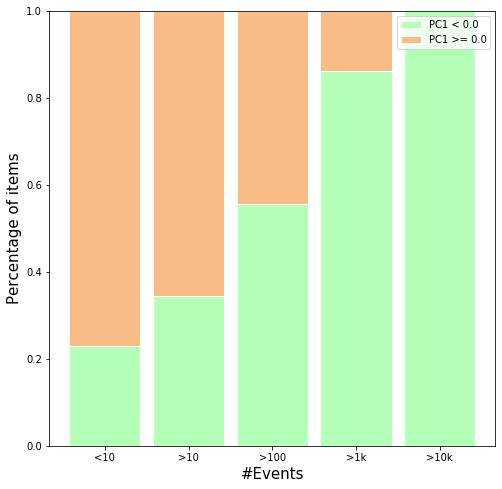

In [12]:
pca_df, data_df = compute_pca('events_per_product.json', 'relevant_product_embeddings.json', 'linear')
scatter_plot_pca(pca_df, 'products_pca.png')
bar_plot_separated(pca_df, 0.0, 'products_pca_groups.png', '<')
# histogram_separated(data_df, 'products_histo.png')
# histogram_separated(pca_df, 'products_pca_histo.png')


>10     170324
>100     70632
>1k       1838
Name: 250, dtype: int64
>100    0.148
>1k     0.162
>10     0.172
Name: 2, dtype: float64


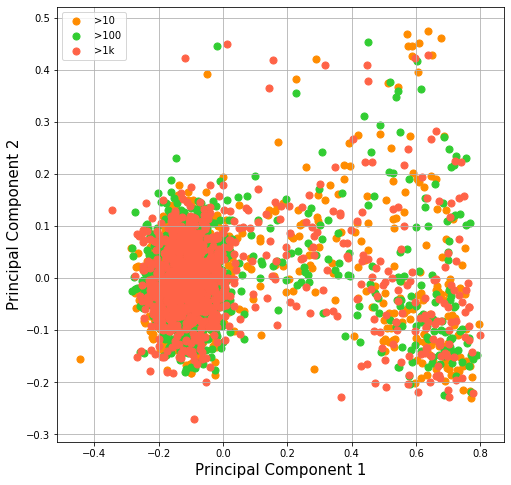

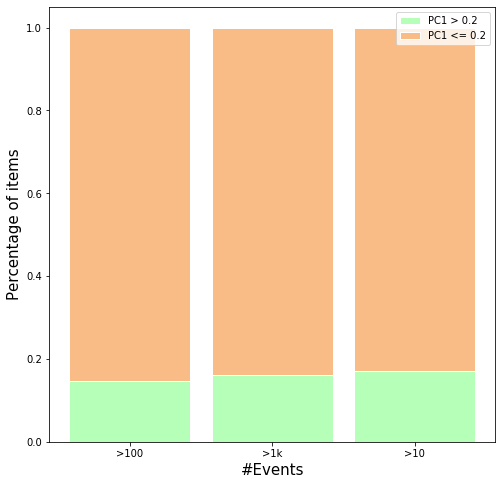

In [11]:
pca_df, data_df = compute_pca('events_per_user.json', 'user_embeddings.json', 'cosine')
scatter_plot_pca(pca_df, 'users_pca.png')
bar_plot_separated(pca_df, 0.2, 'users_pca_groups.png', '>')